In [1]:
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import ast
import random
import torch
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image

In [3]:
file = open('../../data/imagenet_classes.txt', 'r')
labels = ast.literal_eval(file.read())

In [4]:
file = open('../../data/imagenet-a/README.txt', 'r')
lines = file.readlines()
class_mappings = {}
for l in lines[12:-1]:
#     print(l.replace(' \n', '')[:9], l.replace(' \n', '')[10:])
    cls_nbr, cls_name = l.replace(' \n', '')[:9], l.replace(' \n', '')[10:]
    class_mappings[cls_nbr] = cls_name

In [5]:
image_paths = {c: [] for c in class_mappings.values()}
for root, directory, files in os.walk('../../data/imagenet-a'):
    for file in files:
        if '.jpg' in file:
            image_paths[class_mappings[root.split('/')[-1]]].append(root+'/'+file)

Class: digital clock 	 Choice = 0 	 Imagenet class = 530


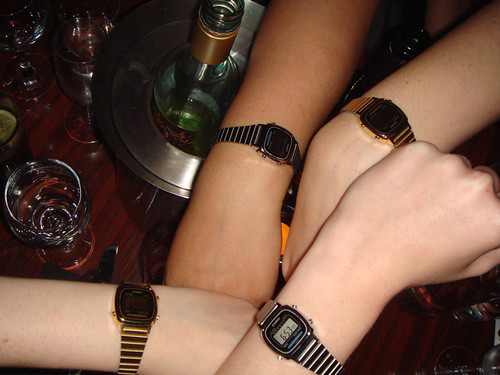

In [6]:
def show_random_image(class_name = None, choice=None, verbose=True):
    if not class_name:
        class_name = random.choice(list(class_mappings.values()))
    if not choice:
        choice = random.choice(range(len(image_paths[class_name])))
    try:
        img_cls = [i for i in range(len(labels)) if class_name.lower() in labels[i].lower()][0]
    except:
        print(class_name)
    if verbose:
        print(f"Class: {class_name} \t Choice = {choice} \t Imagenet class = {img_cls}")
    return img_cls, class_name, choice, Image.open(image_paths[class_name][choice])

img_cls, class_name, choice, image = show_random_image()
image

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocessing = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean, std)])


def get_displ_img(img):
    try:
        img = img.cpu().numpy().transpose((1, 2, 0))
    except:
        img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    displ_img = std * img + mean
    displ_img = np.clip(displ_img, 0, 1)
    displ_img /= np.max(displ_img)
    displ_img = displ_img
    displ_img = np.uint8(displ_img*255)
    return displ_img/np.max(displ_img)

model = models.resnet50(pretrained=True)

In [8]:
model.eval()
def predict(class_name=None, choice=None):
    img_cls, class_name, choice, image = show_random_image(class_name, choice)
    out = model(torch.unsqueeze(preprocessing(image),0))
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    # labels = list(class_mappings.values())
    print("----- prediction -----")
    print(f"Class: {labels[index[0].item()]} \t Percentage: {percentage[index[0]].item()}")
    return image

Class: acorn 	 Choice = 11 	 Imagenet class = 941
----- prediction -----
Class: hornbill 	 Percentage: 71.89251708984375


/home/lisa/anaconda3/envs/ndv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


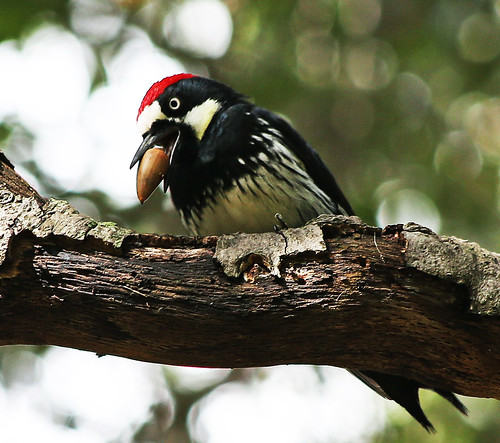

In [9]:
predict()

In [13]:
def generate_cams(img_cls, class_name, choice, image, verbose = True):
    model = models.resnet50(pretrained=True)
    target_layer = model.layer4[-1]
#     img_cls, class_name, choice, image = show_random_image()
    input_tensor = torch.unsqueeze(preprocessing(image), 0)# Create an input tensor image for your model..
    # Note: input_tensor can be a batch tensor with several images!
    model.eval()
    out = model(torch.unsqueeze(preprocessing(image),0))
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    # labels = list(class_mappings.values())

    # top 5
    _, indices = torch.sort(out, descending=True)
    top5_pred = [labels[idx.item()].split(', ')[0] for idx in indices[0][:5]]
    # print(f"Top 5 = {[(labels[idx.item()].split(', ')[0], percentage[idx].item()) for idx in indices[0][:5]]}")
    if verbose:
        print("----- prediction -----")
        print(f"Class: {labels[index[0].item()]} \t Percentage: {percentage[index[0]].item()}")
        print(f"Top 5 {top5_pred}")

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layer=target_layer)

    # If target_category is None, the highest scoring category
    # will be used for every image in the batch.
    # target_category can also be an integer, or a list of different integers
    # for every image in the batch.
    target_category = index.item()

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    pred_cam = cam(input_tensor=input_tensor, target_category=target_category)
    gt_cam = cam(input_tensor=input_tensor, target_category=img_cls)

    # In this example grayscale_cam has only one image in the batch:
    pred_cam = pred_cam[0, :]
    gt_cam = gt_cam[0, :]
    # img = np.array(crop(image))
    img = get_displ_img(torch.squeeze(input_tensor, 0))
    pred_vis = show_cam_on_image(img/np.max(img), pred_cam, use_rgb=True)
    gt_vis = show_cam_on_image(img/np.max(img), gt_cam, use_rgb=True)
    return input_tensor, top5_pred, target_category, img, pred_vis, gt_vis

def display(top5_pred, target_category, img, pred_vis, gt_vis, save=True):
    fig = plt.figure(figsize=(12., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    pred_label = labels[target_category].split(', ')[0]
    for ax, im, caption in zip(grid, [img, pred_vis, gt_vis], ["Original", f"Pred = {pred_label}", f"GT = {class_name}"]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_axis_off()
        ax.set_title(caption, fontsize=18)

    fig.suptitle(f"Class = {class_name}  Index = {choice} \n Top5 Pred = {top5_pred}", fontsize=16, y=0.1)
    if save:
        plt.savefig(f"../examples/{class_name}/{choice}.png", bbox_inches='tight')
        image.save(f"../examples/{class_name}/{choice}-orig.png")
    plt.show()

Class: porcupine 	 Choice = 19 	 Imagenet class = 334
----- prediction -----
Class: armadillo 	 Percentage: 36.84495544433594
Top 5 ['armadillo', 'badger', 'grey fox', 'wombat', 'hyena']


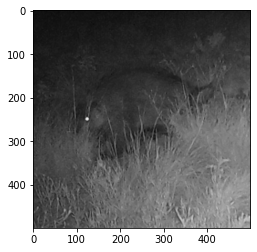

In [14]:
img_cls, class_name, choice, image = show_random_image()
input_tensor, top5_pred, target_category, img, pred_vis, gt_vis = generate_cams(img_cls, class_name, choice, image)
plt.imshow(image)

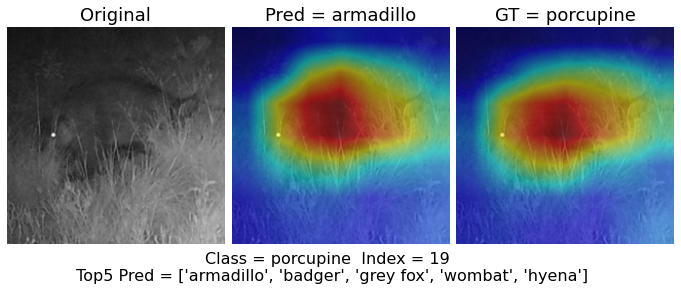

In [15]:
display(top5_pred, target_category, img, pred_vis, gt_vis)

In [31]:
image.size

(375, 500)

In [69]:
def crop(image, horizontal = "right", vertical="center"):
    width, height = image.size
    # Setting the points for cropped image
    if "left" in horizontal:
        left, right  = 0, 224
    elif "right" in horizontal:
        left, right = width-224, width
    elif "center" in horizontal:
        left, right = (width - 224)/2, (width + 224)/2
    if "top" in vertical:
        top, bottom = 0, 224
    elif "bottom" in vertical:
        top, bottom = height-224, height
    elif "center" in vertical:
        top, bottom = (height - 224)/2, (height + 224)/2
    
    # Cropped image of above dimension
    # (It will not change original image)
    return image.crop((left, top, right, bottom))

Class: reel 	 Choice = 3 	 Imagenet class = 758


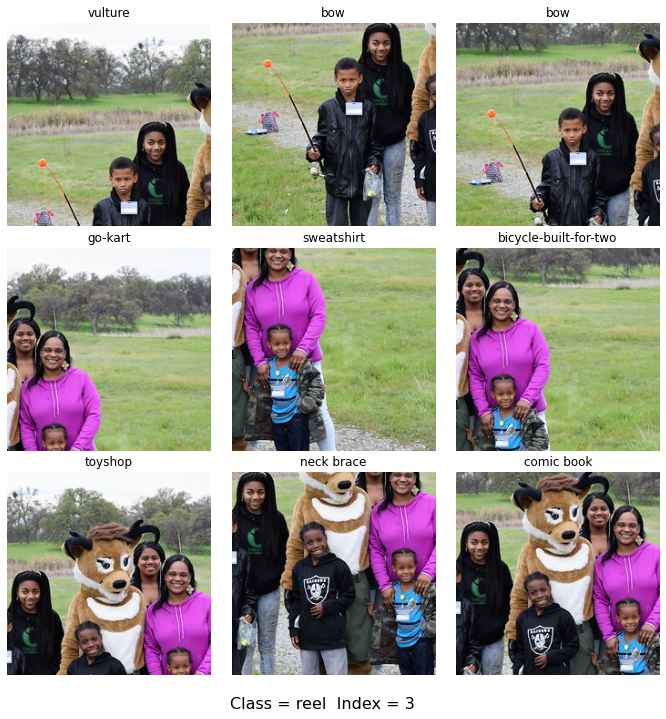

In [103]:
img_cls, class_name, choice, image = show_random_image("reel", 3)
cropped_images = []
cropped_predictions = []
configs = []
for h in ["left", "right", "center"]:
    for v in ["top", "bottom", "center"]:
        cropped_image = crop(image, h, v)
        input_tensor, top5_pred, target_category, img, pred_vis, gt_vis = generate_cams(img_cls, 
                                                                                        class_name, 
                                                                                        choice, 
                                                                                        cropped_image, 
                                                                                        verbose=False)
        cropped_images.append(cropped_image)
        cropped_predictions.append(top5_pred[0])
        configs.append(f"{h} {v}")
#         print(f"{h} {v} \t Pred = {target_category}({top5_pred[0]})")

# display
fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, im, caption in zip(grid, cropped_images, cropped_predictions):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_title(caption, fontsize=12)

fig.suptitle(f"Class = {class_name}  Index = {choice}", fontsize=16, y=0.1)
plt.savefig(f"examples/{class_name}/{choice}-crops.png", bbox_inches='tight')